In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import intfeat as ifs
from pathlib import Path
import math

# Load and plot data

In [2]:
n_train_rows = 1000000
n_test_rows = 100000

int_cols = [f'I_{k}' for k in range(1, 14)]
cat_cols = [f'C_{k}' for k in range(1, 27)]
schema = {'label': pl.Int8()} | {col: pl.Int32() for col in int_cols} | {col: pl.String() for col in cat_cols}

homedir = Path.home()
file_path = homedir / "datasets/criteo_kaggle_challenge/train.txt"

df = pl.read_csv(file_path, has_header=False, separator='\t', schema=schema, n_rows=n_train_rows + n_test_rows)
train_df = df[:n_train_rows, :]
test_df = df[n_train_rows:, :]

In [3]:
pl.concat([
    df[int_cols].quantile(0.95),
    df[int_cols].quantile(0.99),
    df[int_cols].quantile(0.999),
    df[int_cols].max().cast(pl.Float64())
])

I_1,I_2,I_3,I_4,I_5,I_6,I_7,I_8,I_9,I_10,I_11,I_12,I_13
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
14.0,453.0,59.0,24.0,64571.0,470.0,57.0,43.0,425.0,2.0,9.0,4.0,26.0
36.0,2022.0,168.0,39.0,336300.0,1279.0,187.0,48.0,958.0,3.0,23.0,20.0,44.0
100.0,3507.0,1374.0,60.0,844053.0,3810.0,746.0,49.0,2408.0,4.0,55.0,68.0,107.0
780.0,18522.0,65535.0,507.0,2.52703e6,233523.0,8807.0,5064.0,19327.0,8.0,147.0,768.0,6702.0


In [4]:
def get_cutoff(col: np.array, max_val=65536, quantile=0.99, quantile_factor=1.1):
    max_col = np.max(col)
    if max_col < max_val:
        return max_val

    high_quantile = np.quantile(col, quantile)
    return min(high_quantile * quantile_factor, max_val)

In [5]:
def get_subplots(n):
    n_plot_rows = math.floor(math.sqrt(n))
    n_plot_cols = math.ceil(n / n_plot_rows)
    return plt.subplots(n_plot_rows, n_plot_cols, figsize=(4 * n_plot_cols, 3 * n_plot_rows), layout='constrained')

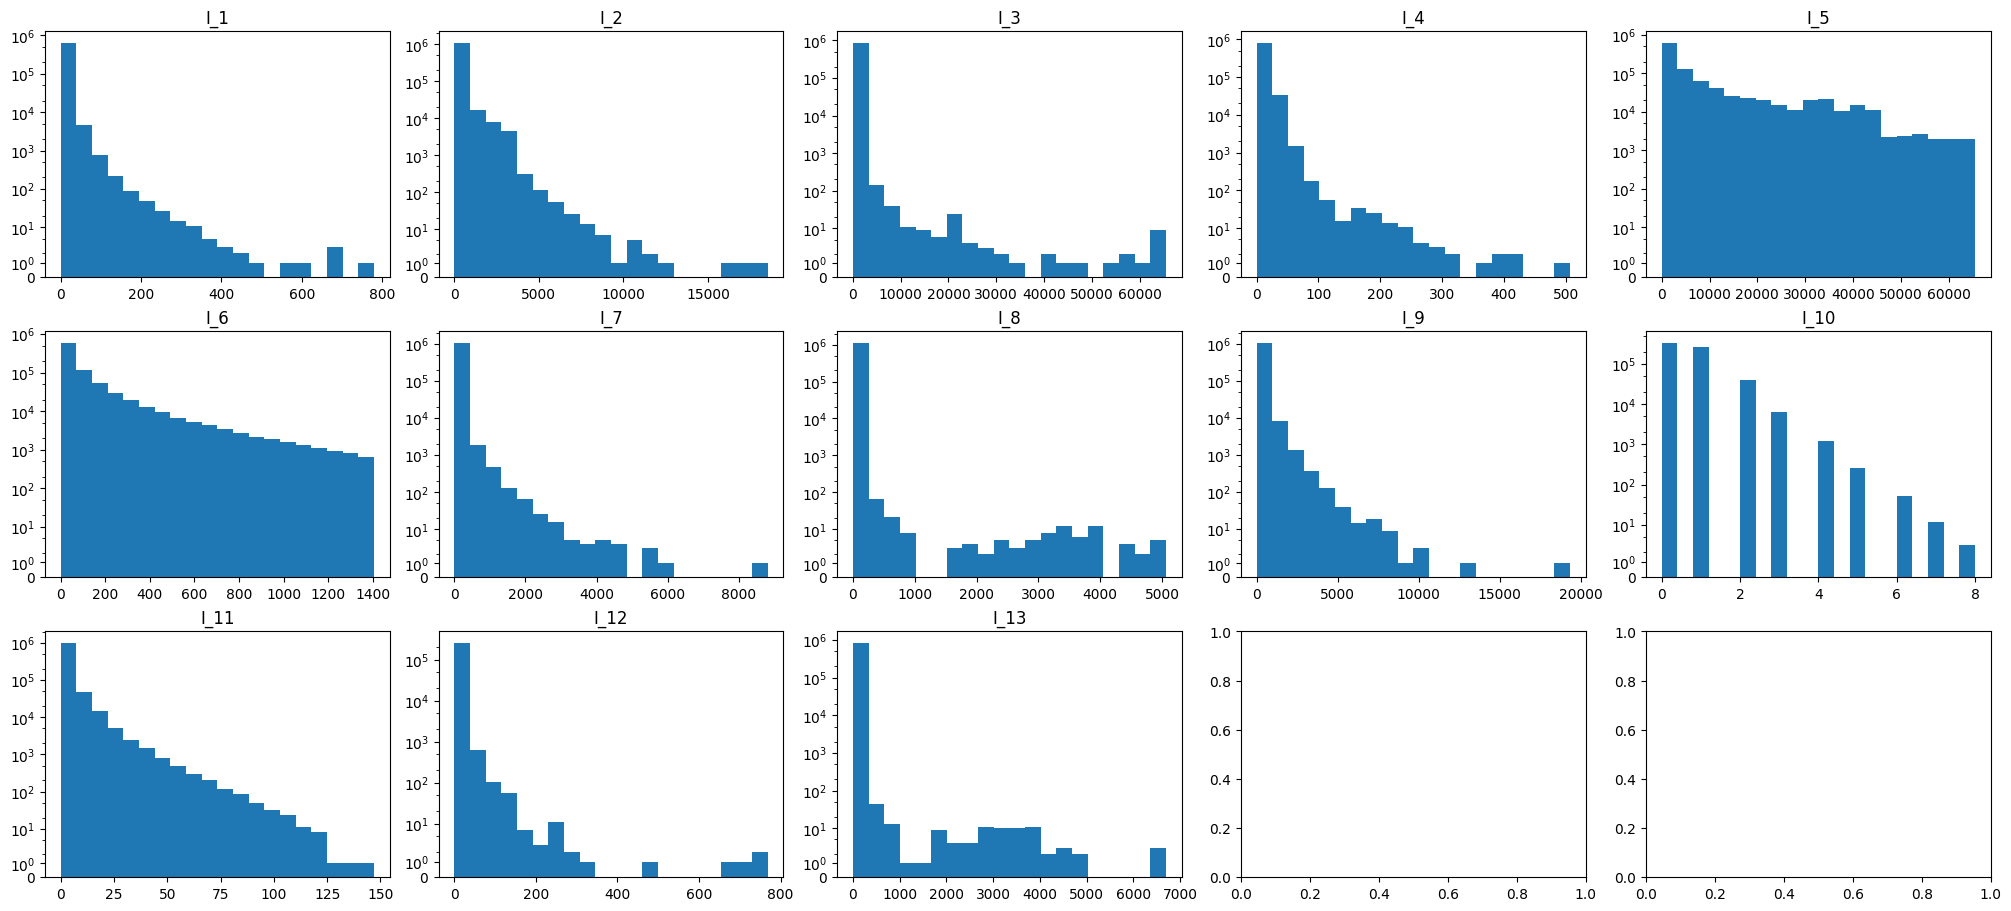

In [6]:
fig, axs = get_subplots(len(int_cols))
for ax, col in zip(axs.ravel(), int_cols):
    col_data = df[col].drop_nulls().to_numpy()
    cutoff = get_cutoff(col_data)
    col_data = col_data[col_data < cutoff]
    ax.hist(col_data, bins=20)
    ax.set_yscale('asinh')
    ax.set_title(col)
plt.show()

# Laplacian-estimation of column distributions

In [7]:
def fit_col(col) -> ifs.LaplacianHistogramFitter:
    col_data = col.drop_nulls().to_numpy()
    fitter = ifs.LaplacianHistogramFitter()
    fitter.fit(col_data)
    return fitter

In [8]:
actual_int_cols = [f'I_{k}' for k in range(1, 14) if k != 10]
fitters = [(col, fit_col(df[col])) for col in actual_int_cols]

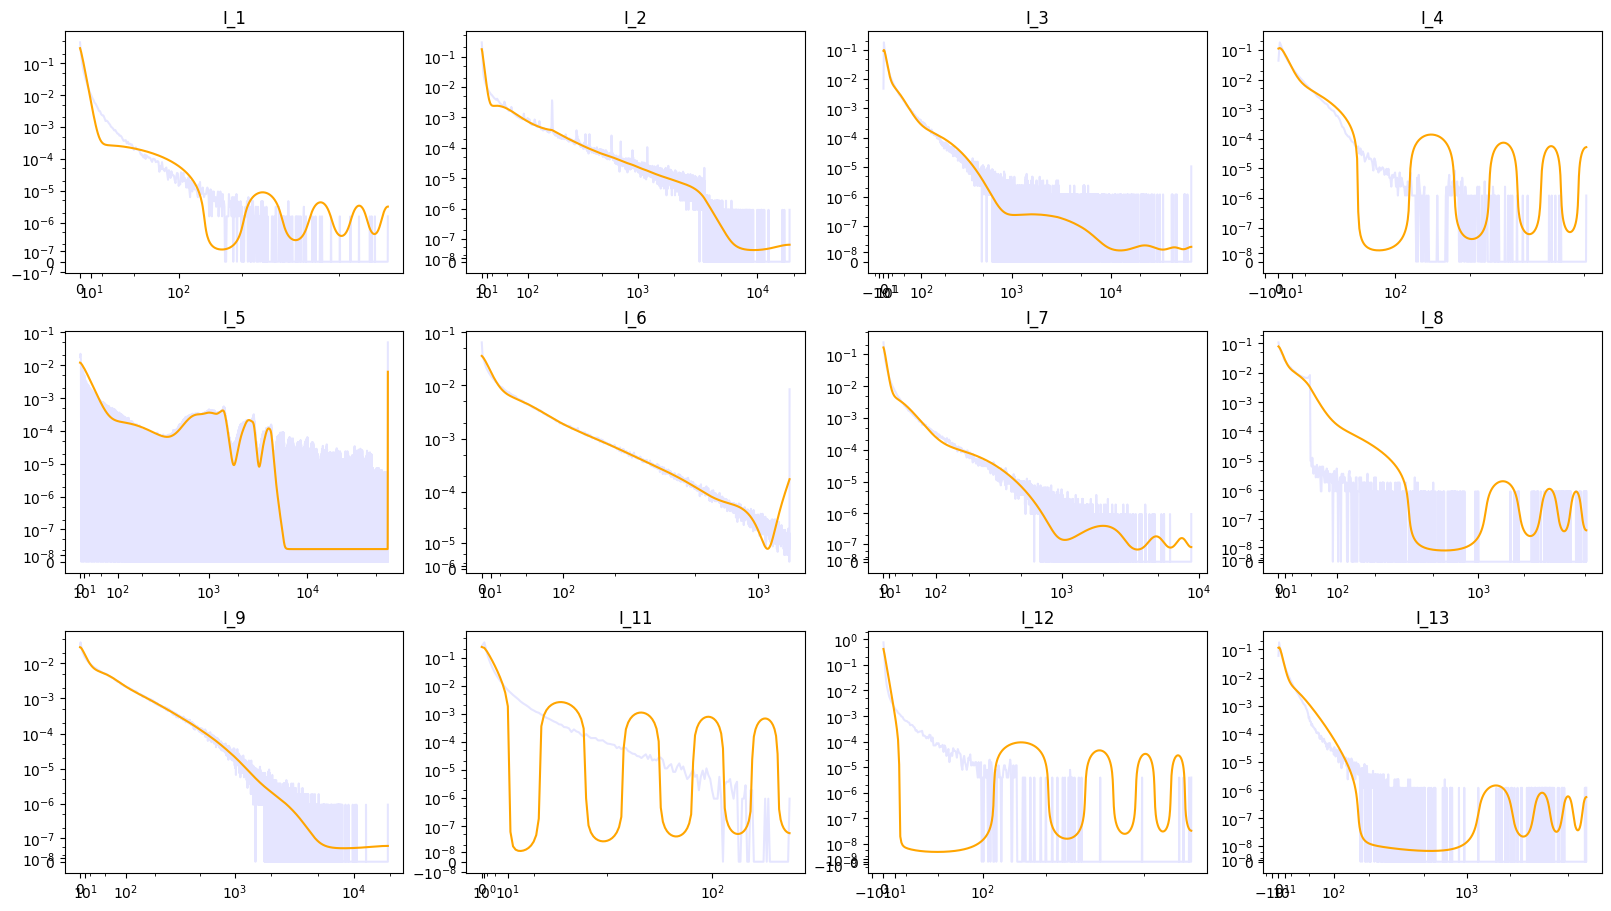

In [9]:
fig, axs = get_subplots(len(fitters))
for ax, (col, fitter) in zip(axs.ravel(), fitters):
    ax.set_title(col)
    ax.plot(np.arange(len(fitter.hist_)), fitter.hist_, color='blue', alpha=0.1)
    ax.plot(fitter.apx_hist_, color='orange')
    ax.set_xscale('asinh', linear_width=100)
    ax.set_yscale('asinh', linear_width=np.min(fitter.apx_hist_))
plt.show()

# Orthogonal basis fitting

In [10]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, KBinsDiscretizer, SplineTransformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.impute import SimpleImputer

In [11]:
def negative_as_missing(inp_df):
    return inp_df.select([
        pl.when(pl.col(col) >= 0).then(pl.col(col)).otherwise(pl.lit(None))
        for col in inp_df.columns
    ])

def nonnegative_as_missing(inp_df):
    return inp_df.select([
        pl.when(pl.col(col) < 0).then(pl.col(col)).otherwise(pl.lit(None))
        for col in inp_df.columns
    ])

In [12]:
pp_int_cols = [f'I_{k}' for k in range(1, 14) if k != 10]
pp_neg_cols = ['I_3']
pp_cat_cols = [f'C_{k}' for k in range(1, 27)] + ['I_10']

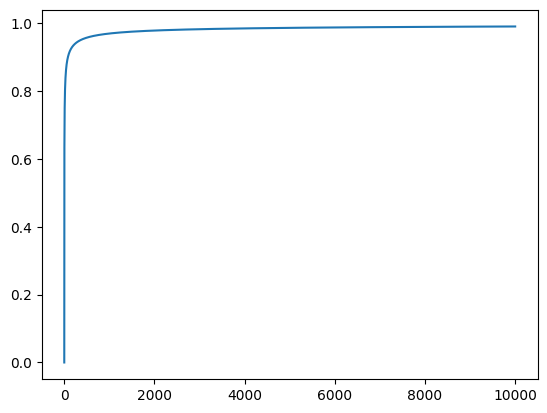

In [ ]:
curvature_spec = curvature_spec=ifs.CurvatureSpec(alpha=0.01, beta=1, center=0)
plt.plot(curvature_spec.compute_weights(np.arange(10000)))

In [66]:
pipeline = make_pipeline(
    make_column_transformer(
        (
            OneHotEncoder(min_frequency=10, handle_unknown='infrequent_if_exist', max_categories=30),
            pp_cat_cols
        ),
        (
            make_pipeline(
                FunctionTransformer(negative_as_missing),
                # ifs.MissingAwareColumnWrapper(
                #     ifs.StrumLiouvilleTransformer(num_funcs=10),
                #     pass_through_missing=True
                # )
                ifs.MissingAwareColumnWrapper(
                    ifs.StrumLiouvilleTransformer(num_funcs=10, curvature_spec=curvature_spec),
                    pass_through_missing=True
                )
                # ifs.MissingAwareColumnWrapper(
                #     SplineTransformer(n_knots=8, knots='quantile'),
                #     pass_through_missing=False
                # )
                # ifs.MissingAwareColumnWrapper(
                #     KBinsDiscretizer(n_bins=10, strategy='quantile', quantile_method='averaged_inverted_cdf'),
                #     pass_through_missing=False
                # )
            ),
            pp_int_cols
        ),
        remainder='drop'
    ),
    LogisticRegression(solver='newton-cholesky')
)

In [67]:
def fit_params(df):
    return df.drop('label'), df['label']

In [68]:
pipeline.fit(*fit_params(train_df))

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehotencoder', ...), ('pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [71]:
feat, labels = fit_params(test_df)
train_ll = log_loss(labels, pipeline.predict_proba(feat)[:, 1])
train_ll

0.4828404772394421

In [72]:
train_auc = roc_auc_score(labels, pipeline.decision_function(feat))
train_auc

0.7536831582087913

In [ ]:
# SL (curvature):              0.48230417718893165, 0.7543511030203502
# Spline (quantile):           0.48256533826108294, 0.7541598290177112
# SL (uniform-c):              0.48299788234333624, 0.7534036165124938
# KBins (quantile):            0.48302296933355615, 0.7533092248896709
# Spline (uniform):            0.4878472470310866,  0.7475094515868766
# KBins (uniform):             0.5005847807039078,  0.7267282834161783